# Required Imports

In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Functions

In [126]:
def normalize_z(df):
    # mean with axis 0 is summing the rows
    return (df - df.mean(axis=0)) / df.std(axis=0) 

def get_features_targets(df, feature_names, target_names):
    df_feature = df[feature_names]
    df_target = df[target_names]
    return df_feature, df_target

def prepare_feature(df_feature):
    cols = len(df_feature.columns) 
    feature = df_feature.to_numpy()
    number_of_samples = feature.shape[0]
    return np.concatenate((np.ones((number_of_samples,1)), feature), axis=1)

def prepare_target(df_target):
    # to_numpy() removes the first column (header column)
    return df_target.to_numpy()

def predict(df_feature, beta):
    X = prepare_feature(normalize_z(df_feature))
    return predict_norm(X, beta)

def predict_norm(X, beta):
    return np.matmul(X,beta)

def split_data(df_feature, df_target, random_state=100, test_size=0.3):
    # get the indexes of the feature 
    indexes = df_feature.index
    # seed the random value 
    if random_state != None:
        np.random.seed(random_state)
    # get the number of test samples to extract 
    k = int(test_size * len(indexes))
    # get the indexes from the features and target to select as test set 
    test_index = np.random.choice(indexes, k, replace=False)
    indexes = set(indexes)
    test_index = set(test_index)
    train_index = indexes - test_index
    df_feature_train = df_feature.loc[train_index, :]
    df_feature_test = df_feature.loc[test_index, :]
    df_target_train = df_target.loc[train_index, :]
    df_target_test = df_target.loc[test_index, :]
    return df_feature_train, df_feature_test, df_target_train, df_target_test

def r2_score(y, ypred):
    sum_res = np.sum((y - ypred)**2)
    error_tot = y - np.mean(y)
    sum_tot = np.sum(error_tot**2)
    return 1-(sum_res/sum_tot)

def adjusted_r2_score(y, ypred, p):
    r2 = r2_score(y, ypred)
    N = y.shape[0]
    x = (1 - r2) * (N - 1)
    y = N - p - 1
    return 1 - ( x/y )

def mean_squared_error(target, pred):
    n = target.shape[0]
    return 1/n * np.sum((target-pred)**2)

def compute_cost(X, y, beta):
    J = 0
    no_of_samples = X.shape[0]
    error = np.matmul(X, beta) - y
    error_sq = np.matmul(error.T, error) # .T is transpose
    J = 1/(2*no_of_samples) * error_sq
    return J[0][0]

def gradient_descent(X, y, beta, alpha, num_iters):
    number_of_samples = X.shape[0]
    J_storage = []
    for i in range(num_iters):
        # STEP 2: compute the derivate with current parameters
        derivative_error = (1/(number_of_samples)) * np.matmul(X.T, (np.matmul(X, beta) - y))
        # STEP 3: update the parameters
        beta = beta - alpha *  derivative_error
        # compute cost at every iteration of beta
        J_storage.append(compute_cost(X, y, beta))
    return beta, J_storage

def transform_features_power(df_feature, colname, colname_transformed, value):
    copy = df_feature.copy()
    copy.loc[:, colname_transformed] = df_feature.loc[:,colname] ** value 
    return copy

def printBeta(beta):
    stringDisplay = "The beta values are "
    for i in range(beta.shape[0]):
        if i == beta.shape[0]-1:
            stringDisplay += str(round(beta[i][0], 2)) + "."
            break
        stringDisplay += str(round(beta[i][0], 2)) + ", "
    print(stringDisplay) 

# 2D TASK 1

## Reading from CSV

We collected the data that relates to death cases of Covid-19 from 38 countries. 

Factors affecting death rate:
   - The number of covid cases
   - The number of people that are fully vaccinated
   - Population Age 65 or above
   - Use of Tobacco
   - Obesity
   - Physician density
   - The number of covid tests

After running several test and visulizations, we found that these are the most relevant to total death cases. So, we decided to use them as predictors. 
   
   1. The number of covid cases
   2. Population Age 65 or above
   3. Obesity
   4. Physician density
   5. The number of people that are fully vaccinated
   
You can see the visulizations by running the following codes.

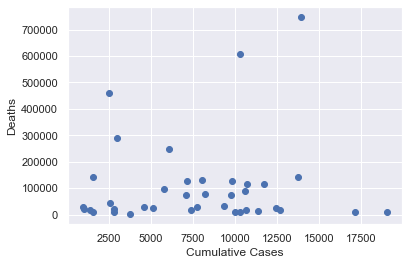

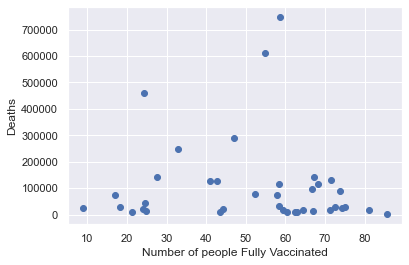

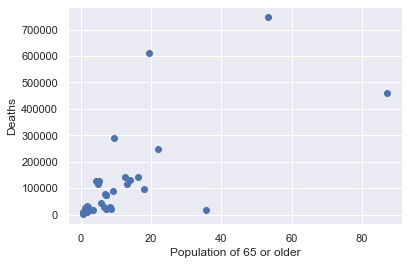

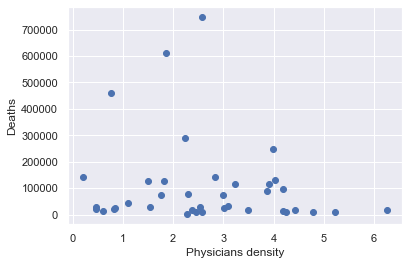

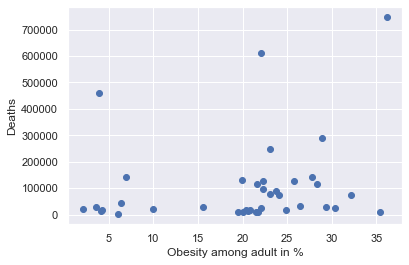

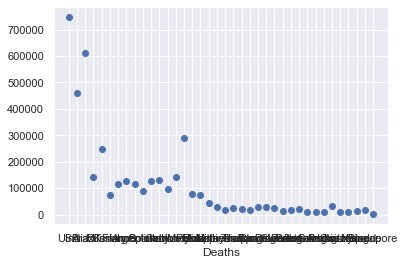

In [127]:
df_task1 = pd.read_csv("DDW_Task1.csv")

df_features, df_target = get_features_targets(df_task1, ["Cases - cumulative total per 100000 population 10-Nov", \
                                                        "Population ages 65 and older (millions).csv", \
                                                        "obesity among adults, bmi above 30 (age-std est %).csv", \
                                                        "PERSONS_FULLY_VACCINATED_PER100 10-Nov", \
                                                        "Physicians density per 1000.csv"],["Deaths - cumulative total 10-Nov"])


plt.scatter(df_features["Cases - cumulative total per 100000 population 10-Nov"], df_target)
plt.xlabel("Cumulative Cases")
plt.ylabel("Deaths")
plt.show()

plt.scatter(df_features["PERSONS_FULLY_VACCINATED_PER100 10-Nov"], df_target)
plt.xlabel("Number of people Fully Vaccinated")
plt.ylabel("Deaths")
plt.show()

plt.scatter(df_features["Population ages 65 and older (millions).csv"], df_target)
plt.xlabel("Population of 65 or older")
plt.ylabel("Deaths")
plt.show()

plt.scatter(df_features["Physicians density per 1000.csv"], df_target)
plt.xlabel("Physicians density")
plt.ylabel("Deaths")
plt.show()

plt.scatter(df_features["obesity among adults, bmi above 30 (age-std est %).csv"], df_target)
plt.xlabel("Obesity among adult in %")
plt.ylabel("Deaths")
plt.show()

plt.scatter(df_task1['Countries'], df_target["Deaths - cumulative total 10-Nov"])
plt.xlabel("Deaths")
plt.show()

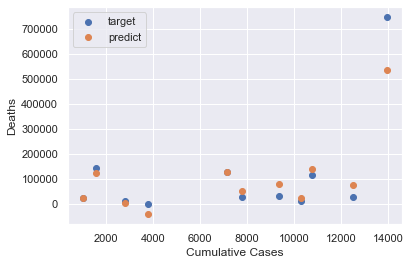

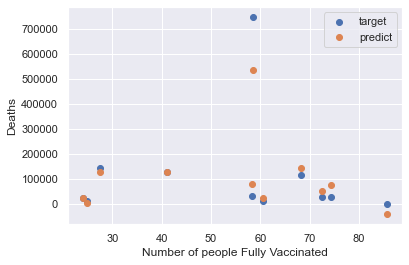

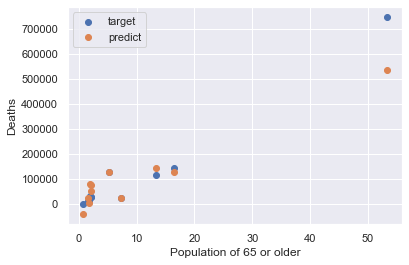

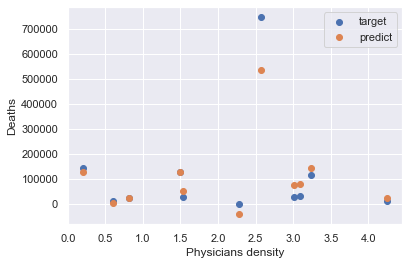

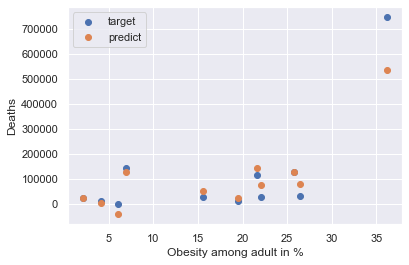

In [128]:
#spliting the data for trainging and testing
df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target)

#normalizing the data
df_features_train_z = normalize_z(df_features_train)

X = prepare_feature(df_features_train_z)
target = prepare_target(df_target_train)

iterations = 1500
alpha = 0.01
#there is five predictor variables and so no of beta values will be six
beta = np.zeros((6,1))

beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)

target = prepare_target(df_target_test)
pred = predict(df_features_test, beta)

sns.set()
plt.scatter(df_features_test["Cases - cumulative total per 100000 population 10-Nov"], target, label="target")
plt.scatter(df_features_test["Cases - cumulative total per 100000 population 10-Nov"], pred, label="predict")
plt.xlabel("Cumulative Cases")
plt.ylabel("Deaths")
plt.legend()
plt.show()

plt.scatter(df_features_test["PERSONS_FULLY_VACCINATED_PER100 10-Nov"], target, label="target")
plt.scatter(df_features_test["PERSONS_FULLY_VACCINATED_PER100 10-Nov"], pred, label="predict")
plt.xlabel("Number of people Fully Vaccinated")
plt.ylabel("Deaths")
plt.legend()
plt.show()

plt.scatter(df_features_test["Population ages 65 and older (millions).csv"], target, label="target")
plt.scatter(df_features_test["Population ages 65 and older (millions).csv"], pred, label="predict")
plt.xlabel("Population of 65 or older")
plt.ylabel("Deaths")
plt.legend()
plt.show()

plt.scatter(df_features_test["Physicians density per 1000.csv"], target, label="target")
plt.scatter(df_features_test["Physicians density per 1000.csv"], pred, label="predict")
plt.xlabel("Physicians density")
plt.ylabel("Deaths")
plt.legend()
plt.show()

plt.scatter(df_features_test["obesity among adults, bmi above 30 (age-std est %).csv"], target, label="target")
plt.scatter(df_features_test["obesity among adults, bmi above 30 (age-std est %).csv"], pred, label="predict")
plt.xlabel("Obesity among adult in %")
plt.ylabel("Deaths")
plt.legend()
plt.show()

In [129]:
# TESTS
printBeta(beta)
target = prepare_target(df_target_test)

a_r2 = adjusted_r2_score(target, pred, beta.shape[0]-1)
print("The Adjusted R Squared value is", round(a_r2, 2))


The beta values are 103998.71, 23675.44, 113172.05, 49172.8, -5969.45, -26908.97.
The Adjusted R Squared value is 0.77



   By using Multiple Linear Regression Model, we are able to predict the number of deaths for a country with 77% accuracy. In order to get this accuracy, we had checked the R squared values of the individual feature with our target (number of death). We have plotted the our model predictions with the target test values which allows us to see how well our predictions is. 

# 2D TASK 2

## Contribution
- Jia Hui - Brainstormed on features, researching, model experimenting
- Pei Xuan - Brainstormed on features, researching, data cleaning
- Min Khant - Brainstormed on features, researching

## Problem Statement

We aim to predict the **daily number of COVID-19 patients** admitted to hospitals in the UK using:

1. **Number of days** from the introduction of the Delta variant to the UK
2. **Vaccination Rate** in the UK

## Relevance
Having an accurate prediction of daily hospital admissions is important for the UK government to ensure sufficient hospital capacity for COVID-19 patients. Due to limitations in public funds, the UK government cannot afford to ramp up hospital capacity beyond what is necessary as this would lead to the wastage of public funds and the underutilization of healthcare resources. Therefore, in order to optimize its resource usage while at the same time preventing the healthcare system from being overstrained, the UK government would require an accurate prediction of daily hospital admissions. Sufficient hospital capacity is a precondition for the safe and successful re-opening of the UK economy and hence, our problem statement is highly relevant to the UK government.



## The Design Opportunity (Discussion on Predictors)

Through our research and explorations using the data, we found that using the number of days from the introduction of the Delta variant to the UK and the vaccination rate enable for more accurate predictions.
This is expected because:

Delta Variant: 

1. The time since the introduction of Delta Variant is a significant factor as the Delta variant is more infectious and leads to increased disease severity. 
2. A longer time period during which the Delta variant is spreading would represent greater transmission of the Delta variant and more people being sick enough to require hospital admission.

Vaccination rates:
1. This also serve as a strong predictor of daily hospital admissions because vaccinations decrease disease severity to a large extent.

While measures of the extent of economic reopening such as the number of visitors to places of retail and recreation as well as the number of public transport commuters are significant factors, we chose to omit them because we found that they decreased the accuracy of our model. 



## Link to Data Sources
### 
- [Hospital Admissions](https://coronavirus.data.gov.uk/details/healthcare)

- [Vaccination Rate](https://coronavirus.data.gov.uk/details/vaccinations)

- [Start of Delta Variant '1/5/2021 as Day 0'](https://www.bbc.com/news/health-57489740)

## Cleaning of Data

1. Took data from 1/6/2021 to 8/11/2021
2. Remove outliers
3. Checked for duplicates
4. Checked for empty cells
5. Arrange data according to date

## All possible models
1. **[Linear Regression](#linear)**
2. **[Polynomial Regression](#poly)**
1. **[Mutiple Regression](#multi)**

## Reading data from CSV

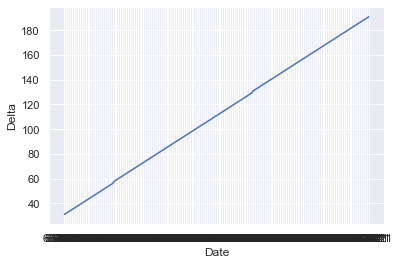

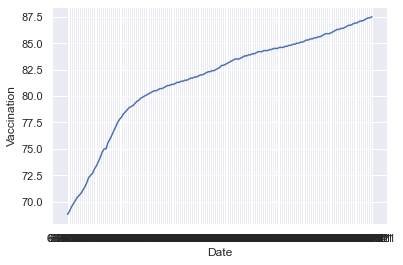

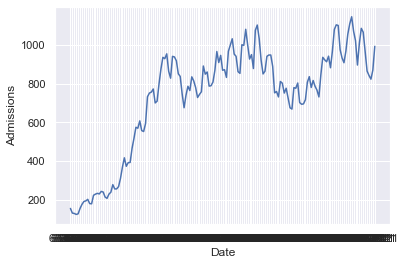

In [130]:

import matplotlib.dates as mdates
df = pd.read_csv("DDW_Task2.csv")

sns.set()
df_feature, df_target = get_features_targets(df,["Date"],["Delta"])
plt.plot(df_feature["Date"], df_target["Delta"])
plt.xlabel("Date")
plt.ylabel("Delta")
plt.show()

df_feature, df_target = get_features_targets(df,["Date"],["Vaccination"])
plt.plot(df_feature["Date"], df_target["Vaccination"])
plt.xlabel("Date")
plt.ylabel("Vaccination")
plt.show()

df_feature, df_target = get_features_targets(df,["Date"],["Admissions"])
plt.plot(df_feature["Date"], df_target["Admissions"])
plt.xlabel("Date")
plt.ylabel("Admissions")
plt.show()


## Discussion on the Data  ^

From the graph, we can see that the number of hospital admissions spike up to around ~990 after about 200 to 235 days from the introduction of the Delta Variant.

However, it remains constant at around 900-1000 hospital admissions per day when vaccination rate hits around 81%

## Features relationship with Target

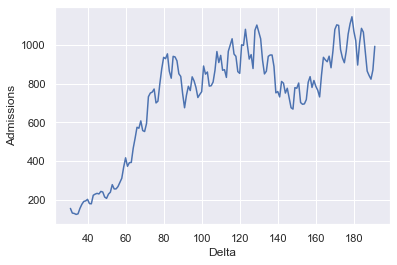

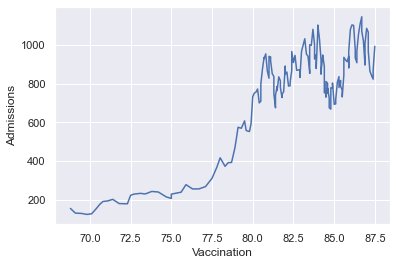

In [131]:
df_feature, df_target = get_features_targets(df,["Delta"],["Admissions"])
plt.plot(df_feature["Delta"], df_target["Admissions"])
plt.xlabel("Delta")
plt.ylabel("Admissions")
plt.show()

df_feature, df_target = get_features_targets(df,["Vaccination"],["Admissions"])
plt.plot(df_feature["Vaccination"], df_target["Admissions"])
plt.xlabel("Vaccination")
plt.ylabel("Admissions")
plt.show()

## ===== **Linear Regression** =====
<a id="linear"></a>

In [132]:
df_feature_delta, df_target = get_features_targets(df,["Delta"],["Admissions"])
df_feature_vaccination, df_target = get_features_targets(df,["Vaccination"],["Admissions"])

## ->Delta

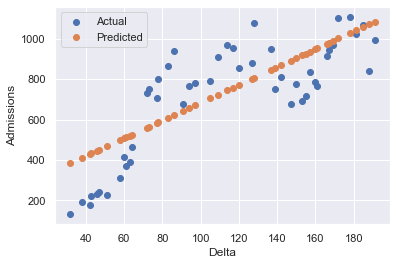

In [133]:
# Delta
df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_feature_delta, df_target)

# normalize features
df_features_train_z = normalize_z(df_features_train)

# change to numpy array and append column for feature
X = prepare_feature(df_features_train_z)
target = prepare_target(df_target_train)

iterations = 1500
alpha = 0.01
beta = np.zeros((2,1))

# call gradient_descent() function
beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)

pred = predict(df_features_test, beta)

plt.scatter(df_features_test["Delta"], df_target_test, label="Actual")
plt.scatter(df_features_test["Delta"], pred, label="Predicted")
plt.ylabel("Admissions")
plt.xlabel("Delta")
plt.legend()

In [134]:
# TESTS
printBeta(beta)
target = prepare_target(df_target_test)

a_r2 = adjusted_r2_score(target, pred, beta.shape[0]-1)
print("The Adjusted R Squared value is", round(a_r2, 2))


The beta values are 737.33, 215.72.
The Adjusted R Squared value is 0.63


## ->Vaccination

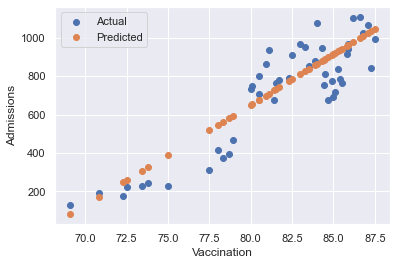

In [135]:
# Transit
df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_feature_vaccination, df_target)

# normalize features
df_features_train_z = normalize_z(df_features_train)

# change to numpy array and append column for feature
X = prepare_feature(df_features_train_z)
target = prepare_target(df_target_train)

iterations = 1500
alpha = 0.01
beta = np.zeros((2,1))

# call gradient_descent() function
beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)

pred = predict(df_features_test, beta)

plt.scatter(df_features_test["Vaccination"], df_target_test, label="Actual")
plt.scatter(df_features_test["Vaccination"], pred, label="Predicted")
plt.ylabel("Admissions")
plt.xlabel("Vaccination")
plt.legend()

In [136]:
# TESTS
printBeta(beta)
target = prepare_target(df_target_test)

a_r2 = adjusted_r2_score(target, pred, beta.shape[0]-1)
print("The Adjusted R Squared value is", round(a_r2, 2))


The beta values are 737.33, 248.83.
The Adjusted R Squared value is 0.79


## ==== **Polynomial Linear Regression** ====
<a id="poly"></a>

## ->Delta

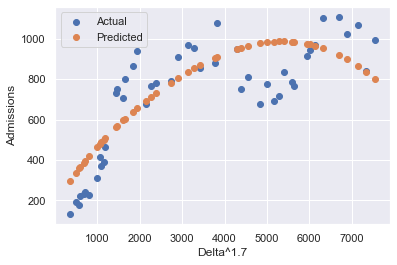

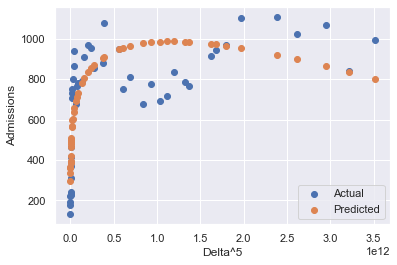

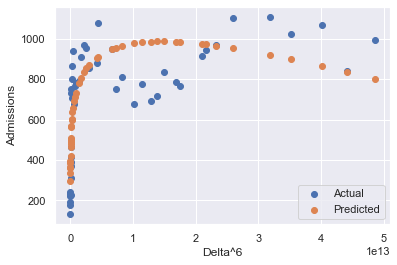

In [137]:
df_features_second = transform_features_power(df_feature_delta, 'Delta', 'Delta^1.7', 1.7)
df_features_second = transform_features_power(df_features_second, 'Delta', 'Delta^5', 5.5)
df_features_second = transform_features_power(df_features_second, 'Delta', 'Delta^6', 6)


# print(df_features_second)

df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features_second, df_target)

# normalize features
df_features_train_z = normalize_z(df_features_train)

# change to numpy array and append column for feature
X = prepare_feature(df_features_train_z)
target = prepare_target(df_target_train)

iterations = 1500
alpha = 0.01
beta = np.zeros((5,1))

# call gradient_descent() function
beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)

pred = predict(df_features_test, beta)

plt.scatter(df_features_test["Delta^1.7"], df_target_test, label="Actual")
plt.scatter(df_features_test["Delta^1.7"], pred, label="Predicted")
plt.ylabel("Admissions")
plt.xlabel("Delta^1.7")
plt.legend()
plt.show()

plt.scatter(df_features_test["Delta^5"], df_target_test, label="Actual")
plt.scatter(df_features_test["Delta^5"], pred, label="Predicted")
plt.ylabel("Admissions")
plt.xlabel("Delta^5")
plt.legend()
plt.show()

plt.scatter(df_features_test["Delta^6"], df_target_test, label="Actual")
plt.scatter(df_features_test["Delta^6"], pred, label="Predicted")
plt.ylabel("Admissions")
plt.xlabel("Delta^6")
plt.legend()
plt.show()

In [138]:
# TESTS
printBeta(beta)
target = prepare_target(df_target_test)

a_r2 = adjusted_r2_score(target, pred, beta.shape[0]-1)
print("The Adjusted R Squared value is", round(a_r2, 2))

# 0.707 , 1.7, 5.5, 6

The beta values are 737.33, 267.09, 105.43, -101.57, -89.92.
The Adjusted R Squared value is 0.65


## ->Vaccination

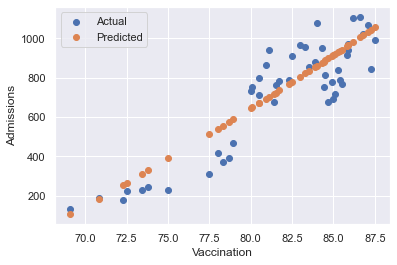

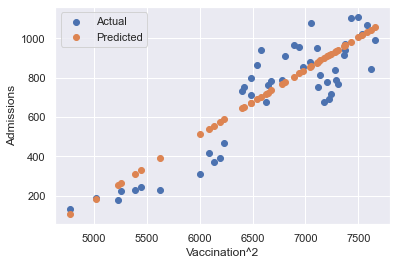

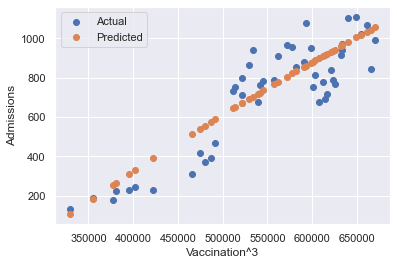

In [139]:
df_features_second = transform_features_power(df_feature_vaccination, 'Vaccination', 'Vaccination^2', 2)
df_features_second = transform_features_power(df_features_second, 'Vaccination', 'Vaccination^3', 3)

# print(df_features_second)

df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features_second, df_target)

# normalize features
df_features_train_z = normalize_z(df_features_train)

# change to numpy array and append column for feature
X = prepare_feature(df_features_train_z)
target = prepare_target(df_target_train)

iterations = 1500
alpha = 0.01
beta = np.zeros((4,1))

# call gradient_descent() function
beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)

pred = predict(df_features_test, beta)


plt.scatter(df_features_test["Vaccination"], df_target_test, label="Actual")
plt.scatter(df_features_test["Vaccination"], pred, label="Predicted")
plt.ylabel("Admissions")
plt.xlabel("Vaccination")
plt.legend()
plt.show()

plt.scatter(df_features_test["Vaccination^2"], df_target_test, label="Actual")
plt.scatter(df_features_test["Vaccination^2"], pred, label="Predicted")
plt.ylabel("Admissions")
plt.xlabel("Vaccination^2")
plt.legend()
plt.show()

plt.scatter(df_features_test["Vaccination^3"], df_target_test, label="Actual")
plt.scatter(df_features_test["Vaccination^3"], pred, label="Predicted")
plt.ylabel("Admissions")
plt.xlabel("Vaccination^3")
plt.legend()
plt.show()

In [140]:
# TESTS
printBeta(beta)
target = prepare_target(df_target_test)

a_r2 = adjusted_r2_score(target, pred, beta.shape[0]-1)
print("The Adjusted R Squared value is", round(a_r2, 2))

The beta values are 737.33, 98.74, 83.02, 66.19.
The Adjusted R Squared value is 0.78


## ==== **Multiple Linear Regression** ====
<a id="multi"></a>

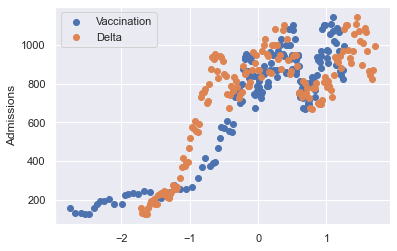

In [141]:
df_features, df_target = get_features_targets(df,["Vaccination", "Delta"],["Admissions"])

df_features = normalize_z(df_features)

plt.scatter(df_features["Vaccination"], df_target, label="Vaccination")
plt.scatter(df_features["Delta"], df_target, label="Delta")
plt.ylabel("Admissions")
plt.legend()


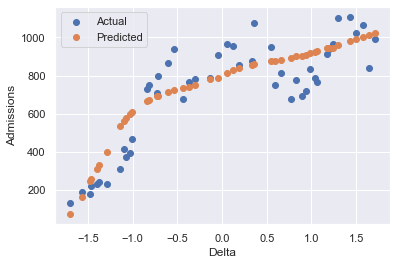

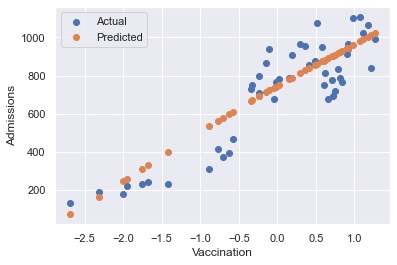

In [142]:
df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target)

# normalize features
df_features_train_z = normalize_z(df_features_train)

# change to numpy array and append column for feature
X = prepare_feature(df_features_train_z)
target = prepare_target(df_target_train)

iterations = 1500
alpha = 0.01
beta = np.zeros((3,1))

# call gradient_descent() function
beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)

pred = predict(df_features_test, beta)

plt.scatter(df_features_test["Delta"], df_target_test, label="Actual")
plt.scatter(df_features_test["Delta"], pred, label="Predicted")
plt.ylabel("Admissions")
plt.xlabel("Delta")
plt.legend()
plt.show()

plt.scatter(df_features_test["Vaccination"], df_target_test, label="Actual")
plt.scatter(df_features_test["Vaccination"], pred, label="Predicted")
plt.ylabel("Admissions")
plt.xlabel("Vaccination")
plt.legend()
plt.show()

In [143]:
# TESTS
printBeta(beta)
target = prepare_target(df_target_test)

a_r2 = adjusted_r2_score(target, pred, beta.shape[0]-1)
print("The Adjusted R Squared value is", round(a_r2, 2))

The beta values are 737.33, 271.29, -30.3.
The Adjusted R Squared value is 0.79


# Model Evaluation

## Discussion on Models & Result

To summarise:

Linear Regression Model Adjusted R Squared:

1. Hospital Admission vs Number of days from introduction of Delta Variant: 0.63
2. Hospital Admission vs Vaccination rate: 0.79

Polynomial Regression Model Adjusted R Squared:

1. Hospital Admission vs Number of days from introduction of Delta Variant: 0.65
2. Hospital Admission vs Vaccination rate: 0.78

Multiple Regression Model Adjusted R Squared: 0.79

Since the number of hospital admissions can be affected by both vaccination rate and the number of days from introduction of Delta Variant, we decided to use **Multiple Regression Model** to predict our target. Multiple Regression Model produce prediction with higher credibility compared to Linear and Polynomial Regression Model.


## Steps taken to improve accuracy of model
1. Logging features
2. Adjusting the power of polynomial linear regression model
3. Removing outliers
4. Research for other possible features:<br/>
    i) Number of Covid Tests Daily<br/> 
    ii) Measurement of visitors to Transit Areas
5. Calculating R Squared value for target and individual features to ensure correlationship
6. Add and remove data from dataset




